<a href="https://colab.research.google.com/github/Shubham619/Airbnb_Analysis/blob/master/DonorsChoose_Screening_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task Name**: DonorsChoose Application screening

>Problem Statement: DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission. They expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:


1.   How to scale current manual processes 
2.   How to increase the consistency of project vetting 
3.   How to focus volunteer time on the important applications



**Objective:** The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school.



Importing all required **libraries**


In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import gc
import os
import random
import nltk
import tensorflow as tf
random.seed(7000)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=6, inter_op_parallelism_threads=5)
from keras import backend
from keras.layers import Input, Dense, Embedding, Flatten, concatenate, Dropout, Convolution1D, \
GlobalMaxPool1D,SpatialDropout1D,CuDNNGRU,Bidirectional,PReLU,GRU
from keras.models import Model
from keras import optimizers
from keras.callbacks import *
from sklearn.metrics import roc_auc_score
tf.compat.v1.set_random_seed(51003)
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf))
from keras.preprocessing import text, sequence
import re
nltk.download('punkt')
import os
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=20,20
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
train=pd.read_csv('/content/drive/My Drive/DonorsChoose/train.csv')
test=pd.read_csv('/content/drive/My Drive/DonorsChoose/test.csv')
sample_submissions=pd.read_csv('/content/drive/My Drive/DonorsChoose/sample_submission.csv')
resources=pd.read_csv('/content/drive/My Drive/DonorsChoose/resources.csv')


# EDA

In [32]:
from pylab import rcParams

def show_bar(train_set,primary_column,f1,f2):
    rcParams['figure.figsize'] = f1,f2
    ax=pd.crosstab(train_set[str(primary_column)], train_set['project_is_approved']).apply(lambda r: r/r.sum()*100, axis=1)
    ax.columns=["Rejected","Accepted"]
    return ax.plot.barh(stacked=True, rot=0)

def show_bar_info(train_set,primary_column,f1,f2):
    ax=pd.crosstab(train_set[str(primary_column)], train_set['project_is_approved']).apply(lambda r: r/r.sum()*100, axis=1)
    ax.columns=["Rejected%","Accepted%"]

    ax1=pd.crosstab(train_set[str(primary_column)], train_set['project_is_approved'])
    ax1.columns=["Rejected_No","Accepted_No"]

    final_ax=pd.merge(ax,ax1,on=str(primary_column),how="inner")
    final_ax=final_ax.sort_values(by='Rejected%',ascending=False)
    final_ax["Total Applications"]=final_ax['Rejected_No']+final_ax['Accepted_No']
    return final_ax

def show_top_bar_info(train_set,top_no,primary_column,f1,f2):
    sx=show_bar_info(train_set,primary_column,f1,f2)
    sx=sx.reset_index()
    return sx.loc[:top_no,:]


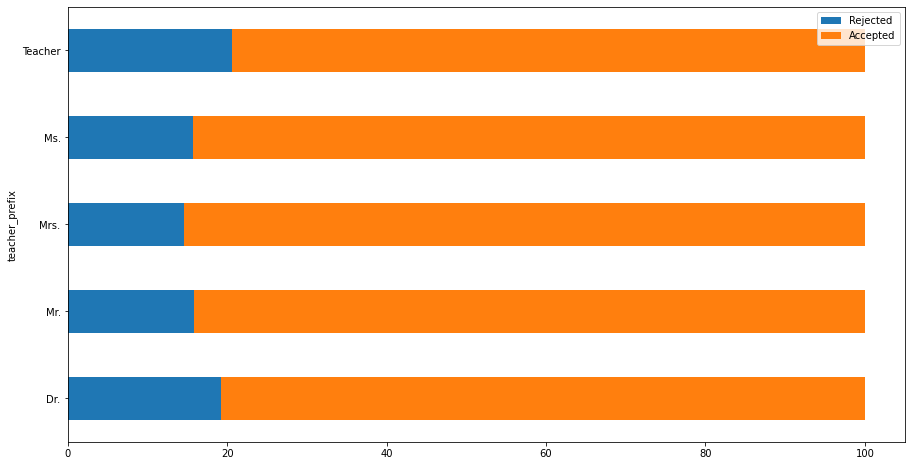

In [10]:
show_bar(train,'teacher_prefix',15,8)

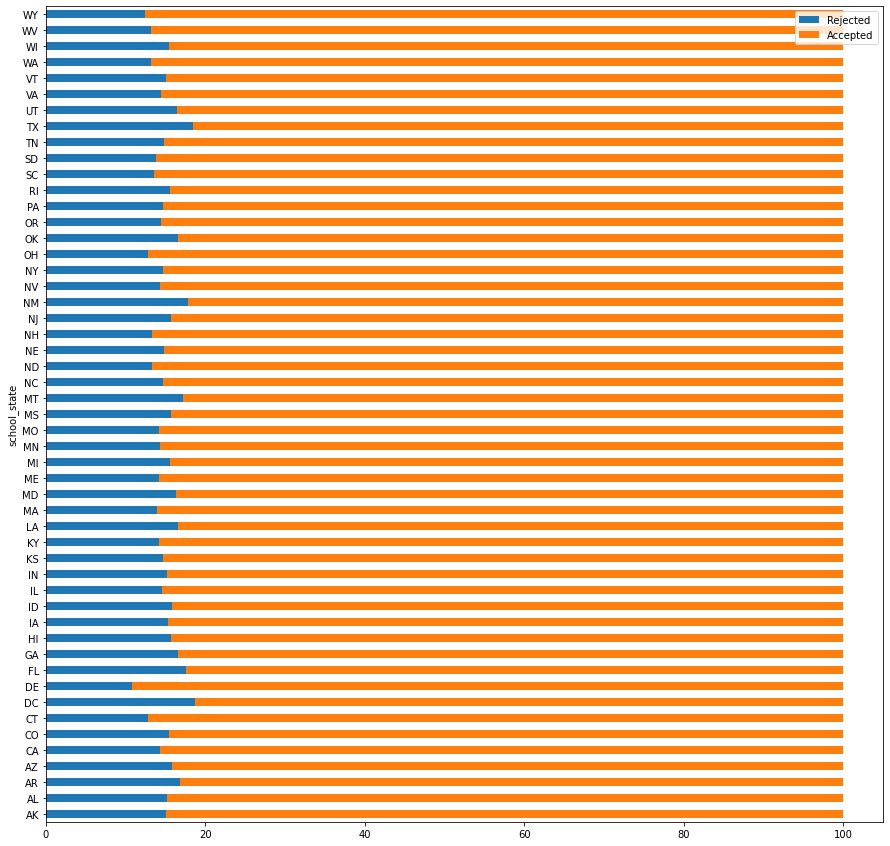

In [11]:
show_bar(train,"school_state",15,15)

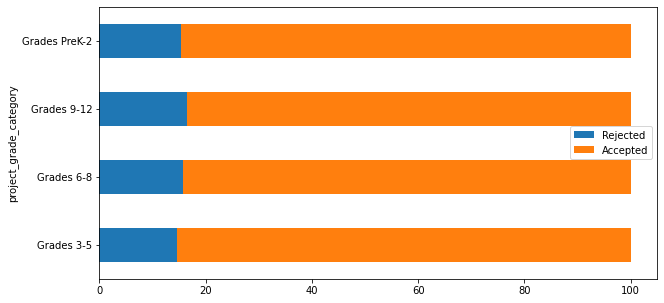

In [12]:
show_bar(train,"project_grade_category",10,5)

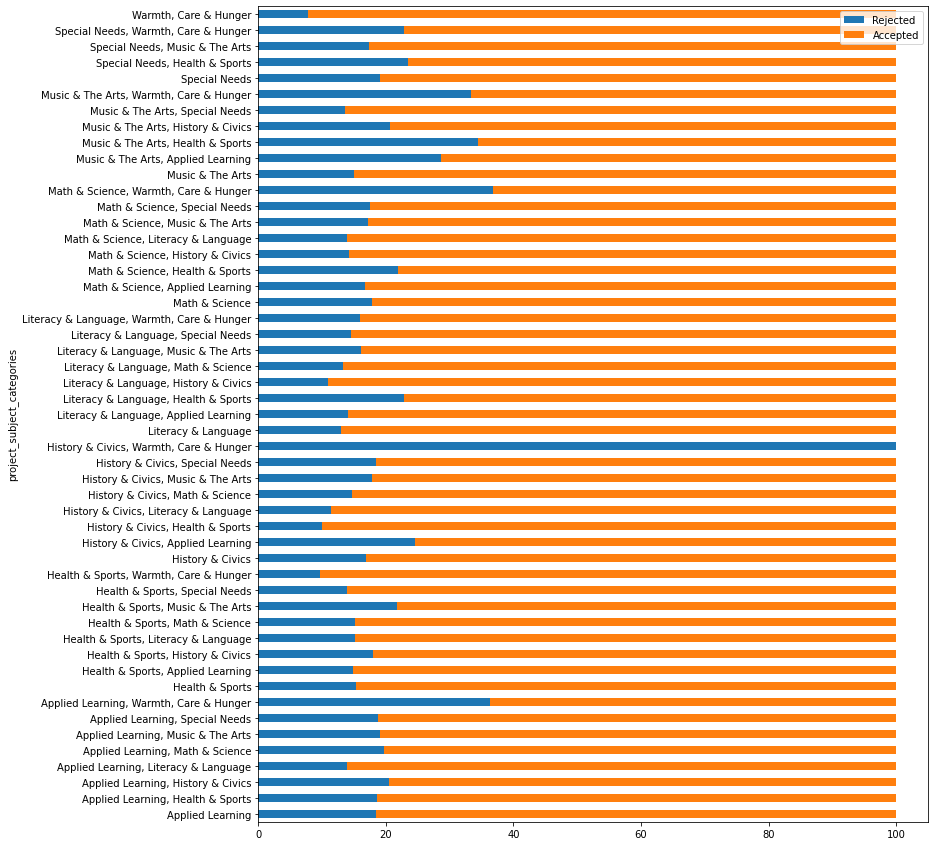

In [13]:
show_bar(train,'project_subject_categories',12,15)

In [14]:
show_bar_info(train,'project_subject_categories',12,12)

Rejected%  Accepted%  \
project_subject_categories                                          
History & Civics, Warmth, Care & Hunger     100.000000   0.000000   
Math & Science, Warmth, Care & Hunger        36.842105  63.157895   
Applied Learning, Warmth, Care & Hunger      36.363636  63.636364   
Music & The Arts, Health & Sports            34.375000  65.625000   
Music & The Arts, Warmth, Care & Hunger      33.333333  66.666667   
Music & The Arts, Applied Learning           28.571429  71.428571   
History & Civics, Applied Learning           24.615385  75.384615   
Special Needs, Health & Sports               23.437500  76.562500   
Special Needs, Warmth, Care & Hunger         22.857143  77.142857   
Literacy & Language, Health & Sports         22.834646  77.165354   
Math & Science, Health & Sports              21.951220  78.048780   
Health & Sports, Music & The Arts            21.755725  78.244275   
Music & The Arts, History & Civics           20.689655  79.310345   
Applied Learning, History & Civics           20.462046  79.537954   
Applied Learning, Math & Science             19.637639  80.362361   
Special Needs                                19.051663  80.948337   
Applied Learning, Music & The Arts           19.016922  80.983078   
Applied Learning, Special Needs              18.823055  81.176945   
Applied Learning, Health & Sports            18.664047  81.335953   
Applied Learning                             18.510301  81.489699   
History & Civics, Special Needs              18.465228  81.534772   
Health & Sports, History & Civics            17.910448  82.089552   
Math & Science                               17.891788  82.108212   
History & Civics, Music & The Arts           17.830882  82.169118   
Math & Science, Special Needs                17.441860  82.558140   
Special Needs, Music & The Arts              17.274472  82.725528   
Math & Science, Music & The Arts             17.203912  82.796088   
History & Civics                             16.802610  83.197390   
Math & Science, Applied Learning             16.755191  83.244809   
Literacy & Language, Music & The Arts        16.122307  83.877693   
Literacy & Language, Warmth, Care & Hunger   16.000000  84.000000   
Health & Sports                              15.320630  84.679370   
Health & Sports, Literacy & Language         15.214067  84.785933   
Health & Sports, Math & Science              15.106383  84.893617   
Music & The Arts                             14.999414  85.000586   
Health & Sports, Applied Learning            14.814815  85.185185   
History & Civics, Math & Science             14.666667  85.333333   
Literacy & Language, Special Needs           14.554974  85.445026   
Math & Science, History & Civics             14.167433  85.832567   
Literacy & Language, Applied Learning        14.065511  85.934489   
Math & Science, Literacy & Language          13.895394  86.104606   
Health & Sports, Special Needs               13.893581  86.106419   
Applied Learning, Literacy & Language        13.879195  86.120805   
Music & The Arts, Special Needs              13.617021  86.382979   
Literacy & Language, Math & Science          13.278093  86.721907   
Literacy & Language                          13.014239  86.985761   
History & Civics, Literacy & Language        11.451049  88.548951   
Literacy & Language, History & Civics        10.950570  89.049430   
History & Civics, Health & Sports            10.000000  90.000000   
Health & Sports, Warmth, Care & Hunger        9.677419  90.322581   
Warmth, Care & Hunger                         7.804655  92.195345   

                                            Rejected_No  Accepted_No  \
project_subject_categories                                             
History & Civics, Warmth, Care & Hunger               1            0   
Math & Science, Warmth, Care & Hunger                 7           12   
Applied Learning, Warmth, Care & Hunger               8           14   
Music & The Arts, Health & 

In [33]:
show_top_bar_info(train,5,"project_subject_categories",10,10)


project_subject_categories   Rejected%  Accepted%  \
0  History & Civics, Warmth, Care & Hunger  100.000000   0.000000   
1    Math & Science, Warmth, Care & Hunger   36.842105  63.157895   
2  Applied Learning, Warmth, Care & Hunger   36.363636  63.636364   
3        Music & The Arts, Health & Sports   34.375000  65.625000   
4  Music & The Arts, Warmth, Care & Hunger   33.333333  66.666667   
5       Music & The Arts, Applied Learning   28.571429  71.428571   

   Rejected_No  Accepted_No  Total Applications  
0            1            0                   1  
1            7           12                  19  
2            8           14                  22  
3           11           21                  32  
4            1            2                   3  
5            6           15                  21

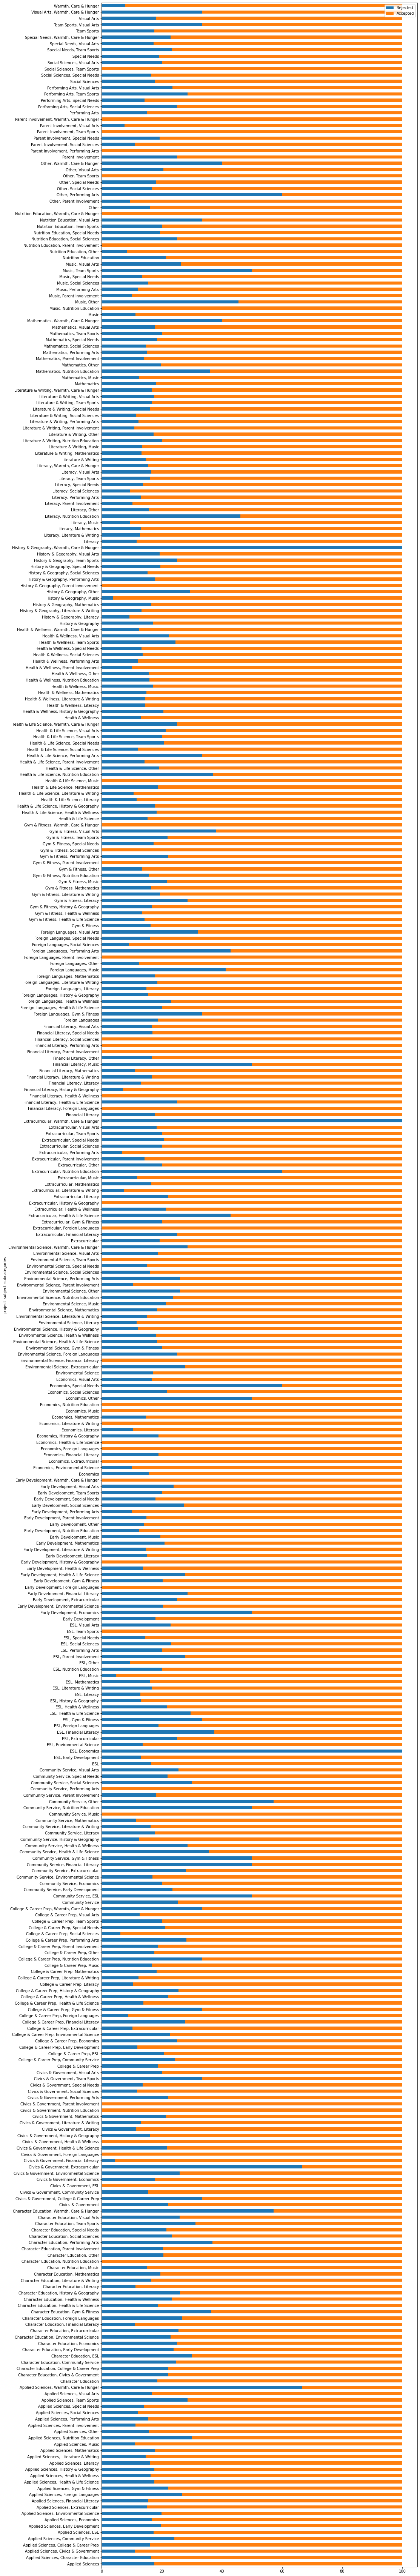

In [16]:
show_bar(train,'project_subject_subcategories',15,125)

In [34]:
show_top_bar_info(train,25,"project_subject_subcategories",10,10)


project_subject_subcategories   Rejected%  Accepted%  \
0                               ESL, Economics  100.000000   0.000000   
1   History & Geography, Warmth, Care & Hunger  100.000000   0.000000   
2       Extracurricular, Warmth, Care & Hunger  100.000000   0.000000   
3      Applied Sciences, Warmth, Care & Hunger   66.666667  33.333333   
4         Civics & Government, Extracurricular   66.666667  33.333333   
5                     Economics, Special Needs   60.000000  40.000000   
6                       Other, Performing Arts   60.000000  40.000000   
7         Extracurricular, Nutrition Education   60.000000  40.000000   
8                     Community Service, Other   57.142857  42.857143   
9   Character Education, Warmth, Care & Hunger   57.142857  42.857143   
10                      Community Service, ESL   50.000000  50.000000   
11                            Economics, Other   50.000000  50.000000   
12                          Music, Team Sports   50.000000  50.000000   
13            Community Service, Gym & Fitness   50.000000  50.000000   
14       Community Service, Financial Literacy   50.000000  50.000000   
15      Community Service, Nutrition Education   50.000000  50.000000   
16                   Financial Literacy, Music   50.000000  50.000000   
17                Early Development, Economics   50.000000  50.000000   
18               Literacy, Nutrition Education   46.153846  53.846154   
19                                Music, Other   45.454545  54.545455   
20          Foreign Languages, Performing Arts   42.857143  57.142857   
21      Extracurricular, Health & Life Science   42.857143  57.142857   
22                    Foreign Languages, Music   41.176471  58.823529   
23          Mathematics, Warmth, Care & Hunger   40.000000  60.000000   
24                Other, Warmth, Care & Hunger   40.000000  60.000000   
25                  Gym & Fitness, Visual Arts   38.095238  61.904762   

    Rejected_No  Accepted_No  Total Applications  
0             1            0                   1  
1             1            0                   1  
2             1            0                   1  
3             2            1                   3  
4             2            1                   3  
5             3            2                   5  
6             3            2                   5  
7             3            2                   5  
8             8            6                  14  
9             4            3                   7  
10            2            2                   4  
11            1            1                   2  
12            5            5                  10  
13            1            1                   2  
14            1            1                   2  
15            3            3                   6  
16            1            1                   2  
17            1            1                   2  
18            6            7                  13  
19            5            6                  11  
20            3            4                   7  
21            3            4                   7  
22            7           10                  17  
23            2            3                   5  
24            2            3                   5  
25            8           13                  21

In [21]:
train['teacher_number_of_previously_posted_projects'].mean()

11.237055140597539

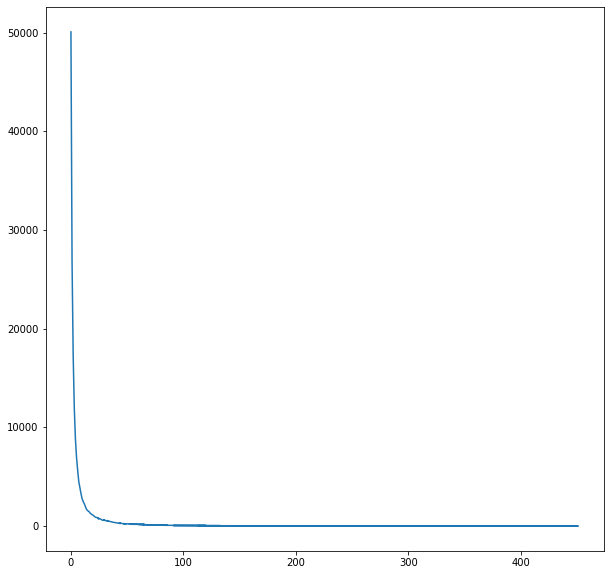

In [37]:
plt.rcParams["figure.figsize"]=10,10
train['teacher_number_of_previously_posted_projects'].value_counts().plot()

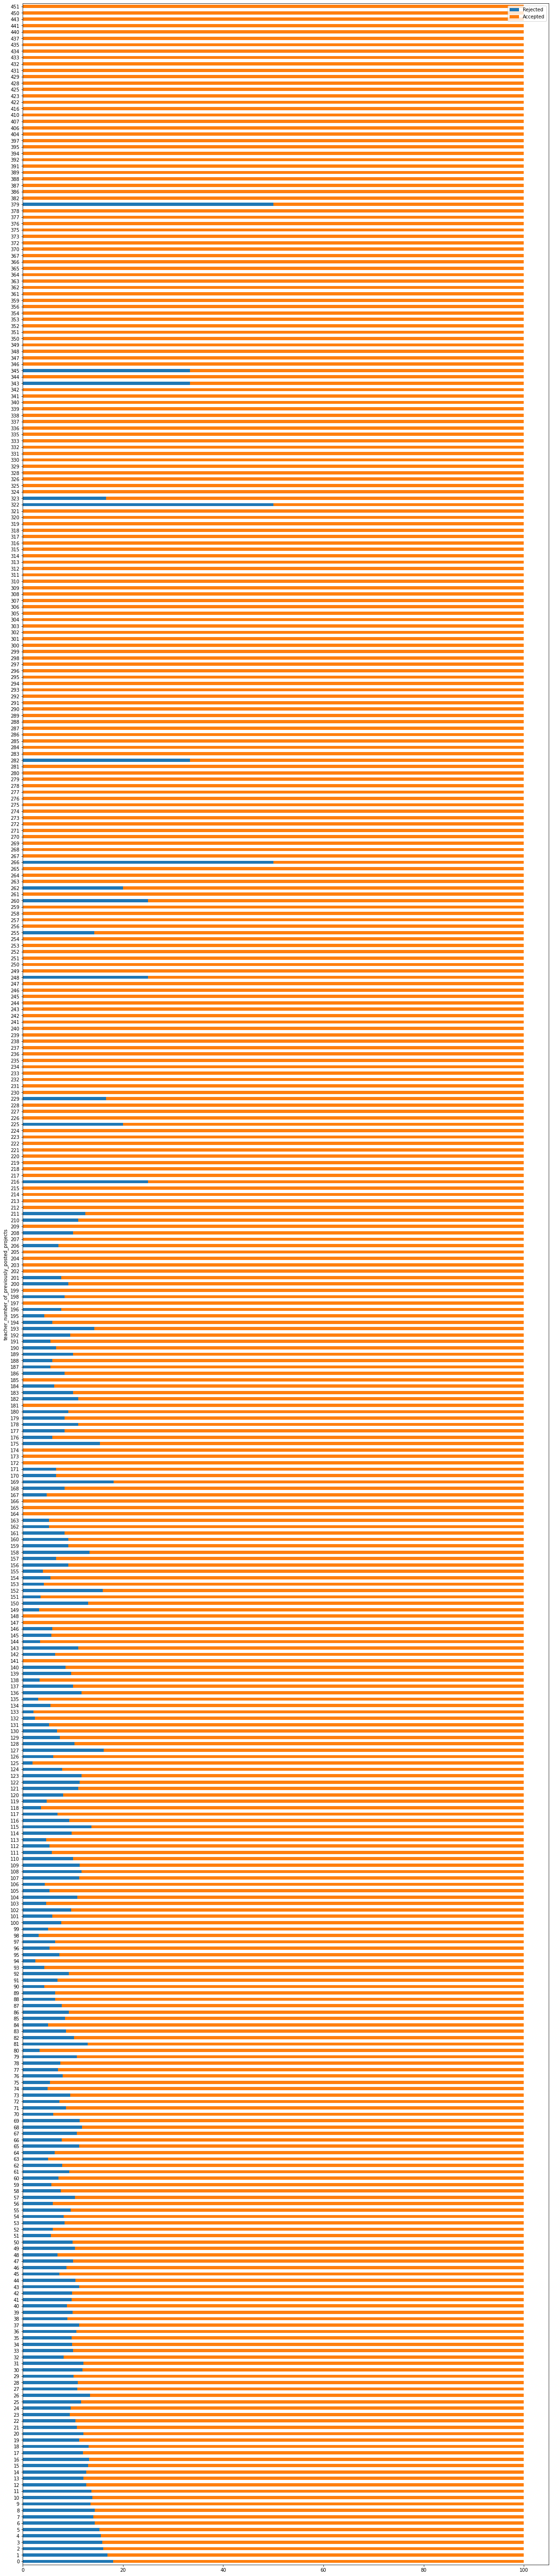

In [38]:

show_bar(train,'teacher_number_of_previously_posted_projects',20,100)

In [35]:
show_top_bar_info(train,25,"teacher_number_of_previously_posted_projects",15,15)

teacher_number_of_previously_posted_projects  Rejected%  Accepted%  \
0                                            379  50.000000  50.000000   
1                                            322  50.000000  50.000000   
2                                            266  50.000000  50.000000   
3                                            345  33.333333  66.666667   
4                                            343  33.333333  66.666667   
5                                            282  33.333333  66.666667   
6                                            260  25.000000  75.000000   
7                                            248  25.000000  75.000000   
8                                            216  25.000000  75.000000   
9                                            262  20.000000  80.000000   
10                                           225  20.000000  80.000000   
11                                           169  18.181818  81.818182   
12                                             0  18.065792  81.934208   
13                                             1  16.901725  83.098275   
14                                           229  16.666667  83.333333   
15                                           323  16.666667  83.333333   
16                                           127  16.129032  83.870968   
17                                             2  16.104891  83.895109   
18                                           152  16.000000  84.000000   
19                                             3  15.866476  84.133524   
20                                             4  15.622513  84.377487   
21                                           175  15.384615  84.615385   
22                                             5  15.318044  84.681956   
23                                             6  14.367100  85.632900   
24                                             8  14.341286  85.658714   
25                                           193  14.285714  85.714286   

    Rejected_No  Accepted_No  Total Applications  
0             1            1                   2  
1             1            1                   2  
2             1            1                   2  
3             1            2                   3  
4             1            2                   3  
5             1            2                   3  
6             1            3                   4  
7             1            3                   4  
8             1            3                   4  
9             1            4                   5  
10            1            4                   5  
11            2            9                  11  
12         9045        41022               50067  
13         4518        22213               26731  
14            1            5                   6  
15            1            5                   6  
16            5           26                  31  
17         2776        14461               17237  
18            4           21                  25  
19         1887        10006               11893  
20         1374         7421                8795  
21            2           11                  13  
22         1062         5871                6933  
23          807         4810                5617  
24          553         3303                3856  
25            2           12                  14

EDA Insights: I have seen no proper impact of (meta data) categorical and numerical variable on rejection rate. We will slightly put our efforts on textual data in approach 1 and then move towards meta-data and textual aprroach


**Different approaches we can use are as follows:**

1.  Tf-Idf vectorizer with logistic classifier 
2.  Use of Word embedding (glove) with GRU
3.  ULMFIT- Transfer leanrning
4.  BERT

*I tried to train ULMFIT (transfer leanring) and BERT but failed due computational power. This is dataset is not normal data set with reviews or feedback, it has multiple essay which is quite heavy to process.*

*I am sure we can expect +3 - 5+ accuracy increase if we used ULMFIT- Transfering learning and +5-8+ if BERT is applied (irrespective you use tensorflow or pytorch)*

# **Approach 1: Tf-idf Vectorizer**

This approach is very common when it comes to text data. 
The main goal of TF-IDF is to scale down the impact of less informative terms in a corpus. Terms e.g (“this”, “will”) which appear frequently but has lesser significance in a corpus. We need to weigh down the frequent word while scaling the rare ones. Most import we need to convert textual data in numbers in a naive langauge.


![alt text](https://drive.google.com/uc?export=view&id=1-EzvlX0tUeT93HdfhkTj8VpMFZNCK5Iw)

For more info please refer my blog on Curx of -Word Embedding:
[Medium Post](https://towardsdatascience.com/the-crux-of-word-embedding-layers-part-1-97e4a612277d)


In [61]:
class Tfidf_logistic_reg:
    def __init__(self,train_path,test_path,submission_path,resource_path,
                 parse_date,random_state,sample_size,actual_train_size,condition_,
                 h_stacking,char_sublinear_tf,char_strip_accents,char_analyzer,char_max_features,
                 word_sublinear_tf,word_strip_accents,word_analyzer,word_max_features,
                 solver,cv,scoring):
        


        ##Importing files
        self.train_path=train_path
        self.test_path=test_path
        self.resource_path=resource_path
        self.submission_path=submission_path
        self.parse_date=parse_date
        self.random_state=random_state
        self.sample_size=sample_size
        self.actual_train_size=actual_train_size
        self.condition_=condition_

        #Vectorizer parameters
        self.h_stacking=h_stacking
        self.char_sublinear_tf=char_sublinear_tf
        self.char_strip_accents=char_strip_accents
        self.char_analyzer=char_analyzer
        self.char_max_features=char_max_features
        self.word_sublinear_tf=word_sublinear_tf
        self.word_strip_accents=word_strip_accents
        self.word_analyzer=word_analyzer
        self.word_max_features=word_max_features
        
        #Modeling parameters
        self.solver=solver
        self.cv=cv
        self.scoring=scoring


    
    def import_files(self):
        skip = sorted(random.sample(range(self.actual_train_size),self.actual_train_size-self.sample_size))
        train=pd.read_csv(str(self.train_path),skiprows=skip,low_memory=self.condition_,index_col="id",parse_dates=[str(self.parse_date)])
        test=pd.read_csv(str(self.test_path),index_col="id",parse_dates=[str(self.parse_date)])
        resource=pd.read_csv(str(self.resource_path),index_col="id").fillna("NotAvailable")
        submission=pd.read_csv(str(self.submission_path),index_col='id')
        print("****Importing completed")
        return train,test,resource,submission
        
    def Aggregation_manipulation(self,train,test,resource):
        training_index = train.index
        testing_index = test.index
        Y=train["project_is_approved"].copy()
        train=train.drop("project_is_approved",axis=1)
        all_=pd.concat([train,test],axis=0)
        all_.drop('teacher_id',axis=1)
        aggregated_resource=resource.reset_index().groupby('id').agg(dict(quantity = 'sum', price = 'sum', 
                                                                          description = lambda x: ' [SEP] '.join(x)))
        all_ = pd.merge(all_,aggregated_resource, left_index=True, right_index=True, how= "inner")
        all_index = all_.index
        del test, train, resource, aggregated_resource
        print('****Aggregation and Manipulation Completed****')
        return all_,all_index,Y,training_index,testing_index
        
    def FeatureEngineering(self,all_):
       
        imp_variables= ['project_subject_categories', 'project_subject_subcategories',
        'project_title', 'project_essay_1', 'project_essay_2',
        'project_essay_3', 'project_essay_4']
        for col in imp_variables:
            all_[col] = all_[col].fillna("NA")
        all_['Parent_Essay'] = all_.apply(lambda x: " ".join(str(x[col]) for col in imp_variables), axis=1)
        
        all_text = all_['Parent_Essay'].copy(deep=True)
    
        print("****Print Feature Engineering Completed****")
     
        return all_,all_text
        
    def Vectorizering(self,all_text,training_index,testing_index):
        # Word Vectorizer
        word_vectorizer = TfidfVectorizer(
            sublinear_tf=self.word_sublinear_tf,strip_accents=self.word_strip_accents,
            analyzer=self.word_analyzer,
            token_pattern=r'\w{1,}',
            ngram_range=(1,1),dtype=np.int32,
            max_features=self.word_max_features
        )

        # Character Vectorizer
        char_vectorizer = TfidfVectorizer(
            sublinear_tf=self.char_sublinear_tf,strip_accents=self.char_strip_accents,
            analyzer=self.char_analyzer,
            ngram_range=(1,4),dtype=np.int32,
            max_features=self.char_max_features
        )
        ##Fitting vectorizer on character and word vectorizer

        word_vectorizer.fit(all_text[training_index])
        char_vectorizer.fit(all_text[training_index])

        ###Applying transform over fitted word and character vectorizer
        train_word_features = word_vectorizer.transform(all_text[training_index])
        train_char_features = char_vectorizer.transform(all_text[training_index])
        

        ###Horizontally stacking Arrays
        print("***Now Horizintally stacking arrays of character and words***")
        if self.h_stacking==1:
            train_features = hstack([train_char_features,train_word_features])
        else:
            train_features = train_word_features
        del train_word_features, train_char_features
        
        test_word_features = word_vectorizer.transform(all_text[testing_index])
        test_char_features = char_vectorizer.transform(all_text[testing_index])
        del word_vectorizer, char_vectorizer, all_text
        
        if self.h_stacking==1:
            test_features = hstack([test_char_features,test_word_features])
        else:
            test_features=test_word_features
        del test_word_features, test_char_features
        

        print("test shape: {} rows, {}".format(*test_features.shape))
        print("****TF-idf has been Completed")
        return train_features,test_features

        
        ##Evaluating model performance after applying simple logistic function
    def Modeling_evaluation(self,train_features,test_features,project_is_approved):
        loss = []
        lr = LogisticRegression(solver=self.solver)
        lr.fit(train_features,project_is_approved)
        print("**Auc**: ",np.mean(cross_val_score(lr, train_features, project_is_approved, cv=self.cv, scoring=self.scoring)))
        sub = pd.DataFrame(lr.predict_proba(test_features)[:, 1],columns=["project_is_approved"],index=testing_index)
        return sub
    


A Class Tfidf_logistic_reg  has been created.Its ready to use.
`We have to pass all the required parameter`.


1.   Import files method Params
 *   Training data path
 *   Testing data path 
 *   Sample submission data path
 *   Resources data path 
 *   Name of date column 
 *   Random state 
 *   Sample size of train data 
 *   Actual train data size
 *   Low memory condition
 
 


2.   Aggregation and Manipulation method params
 *   Requires no additional parameters since it's 1+1=2 stage
 *   

3.   Feature Engineering params
 *   Requires no additional explicit parameters required


4.   Vectorizing params
 *   Sublinear transform required
 *   Accents
 *   Analyzer name
 *   Max features

5.   Modeling and Evaluation params
 *   Solver used (l2 penalty)
 *   Cross validation
 *   Scoring metric



**Main Class defination**

In [63]:
class_p=Tfidf_logistic_reg('/content/drive/My Drive/DonorsChoose/train.csv',
              '/content/drive/My Drive/DonorsChoose/test.csv',
              '/content/drive/My Drive/DonorsChoose/sample_submission.csv',
              '/content/drive/My Drive/DonorsChoose/resources.csv',
             'project_submitted_datetime',45,120000,182080,True,1,
              True,'unicode','char',5000,
              True,'unicode','word',8000,
              "sag",3,'roc_auc')

**2.1 Calling method** `import files`

In [53]:
train,test,resource,submission=class_p.import_files()

****Importing completed


In [54]:
print("Imported Train data",train.info())
print("Imported Test data with shape",test.shape)
print("Imported Resource file with shape",resource.shape)
print("Imported Submission file with shape",submission.shape)
       

<class 'pandas.core.frame.DataFrame'>
Index: 120000 entries, p036502 to p190772
Data columns (total 15 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   teacher_id                                    120000 non-null  object        
 1   teacher_prefix                                119997 non-null  object        
 2   school_state                                  120000 non-null  object        
 3   project_submitted_datetime                    120000 non-null  datetime64[ns]
 4   project_grade_category                        120000 non-null  object        
 5   project_subject_categories                    120000 non-null  object        
 6   project_subject_subcategories                 120000 non-null  object        
 7   project_title                                 120000 non-null  object        
 8   project_essay_1                               120000

  **2.2. Calling** `Aggregation and Manipulation method`





In [59]:
all_,all_index,Y,training_index,testing_index=class_p.Aggregation_manipulation(train,test,resource)

****Aggregation and Manipulation Completed****


**2.3 Calling** `Feature Engineering method`

In [64]:
all_,all_text=class_p.FeatureEngineering(all_)

****Print Feature Engineering Completed****


**2.4 Calling** `Vectorizing method`

In [65]:
 train_features,test_features=class_p.Vectorizering(all_text,training_index,testing_index)

***Now Horizintally stacking arrays of character and words***
test shape: 78035 rows, 13000
****TF-idf has been Completed


**2.5 Calling** `Modeling and Evaluation method`

In [68]:
submission=class_p.Modeling_evaluation(train_features,test_features,Y)

**Auc**: 0.7543016672


Explanation:
This task is not just about textual data but also categorical and numeric data. The meta information plays and important role and improves the performance of model even though if their is not significant impact of additional meta data.

We have used following columns
1. 'project_subject_categories', 
2. 'project_subject_subcategories',
3. 'project_title', 
4. 'project_essay_1',
5. 'project_essay_2',
6. 'project_essay_3',
7. 'project_essay_4

In this approach i have used simple textual based scenario. Even without meta information i was able to get nice performance.

**Kaggle Public score:** **0.76156**


# Approach 2: Glove pre-trained embedding with GRU (kind of LSTM)

**GLOVE:** Global Vectors for Word Representation, or GloVe, is an unsupervised learning algorithm for obtaining vector representations for words. GloVe allows us to take a corpus of text, and intuitively transform each word in that corpus into a position in a high-dimensional space. This means that similar words will be placed together. (You can connect it will occurrence matrix or cosine similarity


![alt text](https://drive.google.com/uc?export=view&id=1Zqr1ezCTzr_u6kOYLvwOtq9-nhW9v6rf)

**GRU:** GRUs are improved version of RNN. But what makes them so special and effective is that to solve the vanishing gradient problem of a standard RNN, GRU uses, so-called, update gate and reset gate. GUR are faster compare to LSTM.

![alt text](https://drive.google.com/uc?export=view&id=1cCaowBdNgo_gr8F7kFCQofaO_NQLqSTY)




 [To connects the dots check my story - LSTM from scratch:](https://medium.com/@shubham.deshmukh705/lstm-made-easy-b669333dd661)

In [47]:
class Embedding_GRU:
    def __init__(self,train_path,test_path,sample_submissions_path,resources_path,
                 max_features,max_size,maxlen,embedding_location,embedding_size,
                 drop_out_rate,spatial_dropout,gru_units,con1d_units,activation,
                 embedding_dim,dense_layer_inp_dim,last_dense_input_dim,loss,metric,decay,lr,last_layer_activation,last_layer_dropout):
        
        ### Import files params
        self.train_path=train_path
        self.test_path=test_path
        self.sample_submissions_path=sample_submissions_path
        self.resources_path=resources_path

        #Aggregation and manipulation params

        self.max_features=max_features
        self.max_size=max_size

        ##Feature Engineering paras
        self.maxlen=maxlen

        ##Embedding params
        self.embedding_location=embedding_location
        self.embedding_size=embedding_size

        ##NN GRU params        
        self.drop_out_rate=drop_out_rate
        self.spatial_dropout=spatial_dropout
        self.gru_units=gru_units
        self.con1d_units=con1d_units
        self.activation=activation
        self.embedding_dim=embedding_dim
        self.dense_layer_inp_dim=dense_layer_inp_dim
        self.last_dense_input_dim=last_dense_input_dim
        self.loss=loss
        self.metric=metric
        self.decay=decay
        self.lr=lr
        self.last_layer_activation=last_layer_activation
        self.last_layer_dropout=last_layer_dropout

    def import_files(self):
        train=pd.read_csv(self.train_path)
        test=pd.read_csv(self.test_path)
        sample_submissions=pd.read_csv(self.sample_submissions_path)
        resources=pd.read_csv(self.resources_path)
        return train,test,sample_submissions,resources

    def Aggregation_manipulation(self,train,test,resources):
        ##sorting training data by project_submitted_datetime
        train = train.sort_values(by="project_submitted_datetime")

        ##import textual columns
        imp_variables= ['project_subject_categories', 'project_subject_subcategories',
        'project_title', 'project_essay_1', 'project_essay_2',
        'project_essay_3', 'project_essay_4', 'project_resource_summary']


        ##extracting essence from meta data
        resources['total_price'] = resources.quantity * resources.price

        ##grouping by id as a single id has multiple resources records found
        mean_total_price = (resources.groupby('id').total_price.mean()) 
        sum_total_price = (resources.groupby('id').total_price.sum()) 
        count_total_price = (resources.groupby('id').total_price.count())
        mean_total_price['id'] = mean_total_price.index
        sum_total_price['id'] = mean_total_price.index
        count_total_price['id'] = mean_total_price.index

        def expand_f(df):
            df = pd.merge(df, mean_total_price, on='id')
            df = pd.merge(df, sum_total_price, on='id')
            df = pd.merge(df, count_total_price, on='id')
            df['year'] = df.project_submitted_datetime.apply(lambda x: x.split("-")[0])
            df['month'] = df.project_submitted_datetime.apply(lambda x: x.split("-")[1])
            for col in imp_variables:
                df[col] = df[col].fillna("NA")
            df['text'] = df.apply(lambda x: " ".join(x[col] for col in imp_variables), axis=1)
            return df

        train = expand_f(train)
        test = expand_f(test)

        ##selecting categrorical features and numerical features
        cat_features = ["teacher_prefix", "school_state", "year", "month", "project_grade_category", "project_subject_categories", "project_subject_subcategories"] 
        num_features = ["teacher_number_of_previously_posted_projects", "total_price_x", "total_price_y", "total_price"]
        cat_features_hash = [col+"_feature_hashing" for col in cat_features]

        def feature_hash(df, max_size=self.max_size):
            for col in cat_features:
                df[col+"_feature_hashing"] = df[col].apply(lambda x: hash(x)%self.max_size)
            return df

        train = feature_hash(train)
        test = feature_hash(test)


        ## standarizing some numeric features so that mean 0 and std=1
        scaler = StandardScaler()
        X_train_num = scaler.fit_transform(train[num_features])
        X_test_num = scaler.transform(test[num_features])

        ##converting datatpye of some features to integer
        X_train_cat = np.array(train[cat_features_hash], dtype=np.int)
        X_test_cat = np.array(test[cat_features_hash], dtype=np.int)
        tokenizer = text.Tokenizer(num_words=self.max_features)
        return train,test,X_train_num,X_test_num,X_test_cat,X_train_cat

    def Feature_Engineering(self,train,test):

        ##cleaning textual data
        cleaning=lambda x :  re.sub(r'(\")|(\r)|(\n)|(\r\n)|(\\)|\t|\:|\"\"\"\"|_|\+|\=', ' ', str(x))
        

        train["text"]=train["text"].map(cleaning)
        test["text"]=test["text"].map(cleaning)

        ##tokenzing textual data
    
        tokenizer = text.Tokenizer(num_words=self.max_features)
        tokenizer.fit_on_texts(train["text"].tolist()+test["text"].tolist())

        ##seq2seq updates internal vocabulary based on a list of sequences.
        list_tokenized_train = tokenizer.texts_to_sequences(train["text"].tolist())
        list_tokenized_test = tokenizer.texts_to_sequences(test["text"].tolist())

        ###post padding so as to maintain same len throughout
        X_train_words = sequence.pad_sequences(list_tokenized_train, maxlen=self.maxlen)
        X_test_words = sequence.pad_sequences(list_tokenized_test, maxlen=self.maxlen)
        X_train_target = train.project_is_approved

        return X_train_words,X_test_words,X_train_target
    
    
    def glove_Embedding(self):
        
        ##passing glove wiki1O3 300d 1M file
        EMBEDDING_FILE = self.embedding_location
        embed_size=self.embedding_size
        embeddings_index = {}

        ##opening embedding text file using open function
        with open(EMBEDDING_FILE,encoding='utf8') as f:
            ##iterating over each line
            for line in f:
                ##splitting iterated line
                values = line.rstrip().rsplit(' ')
                ##considering only zeroth index
                word = values[0]
                ##converting coefficients to float32 to save memory
                coefs = np.asarray(values[1:], dtype='float32')
                ##assigning coefficient to embedding_index 
                embeddings_index[word] = coefs

        ###preparing embedding matrix
        word_index = tokenizer.word_index
        num_words = min(self.max_features, len(word_index) + 1)
        embedding_matrix = np.zeros((num_words, embed_size))
        for word, i in word_index.items():
            if i >= self.max_features:
                continue
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        return embedding_matrix

    def Modeling_nn(self,embedding_matrix,X_train_num,X_test_num,X_test_cat,X_train_cat,X_train_target,X_train_words):

        ##passing  input layers as input_categroical, input_numbers, total words

        input_cat = Input((len(cat_features_hash), ))
        input_num = Input((len(num_features), ))
        input_words = Input((self.maxlen, ))
        ##applying embedding layer with input as max_size and output with 10 dim
        x_cat = Embedding(self.max_size, 10)(input_cat)
        ## droping out some elements same through all channels
        x_cat = SpatialDropout1D(self.spatial_dropout)(x_cat)

        ###flatting into 1 dim
        x_cat = Flatten()(x_cat)
        ##Creating embedding layer with input as maxfeatures and embedding dimenion 
        x_words = Embedding(self.max_features, self.embedding_dim,
        weights=[embedding_matrix],trainable=False)(input_words)
        x_words = SpatialDropout1D(self.spatial_dropout)(x_words)
        ##applying bi-directional gru with some input_units
        x_words =Bidirectional(GRU(self.gru_units, return_sequences=True))(x_words)
        ## passes over data segments of the overall data set  with height three
        x_words = Convolution1D(self.con1d_units, 3, activation="relu")(x_words)
        ##max pooling to reduce dim
        x_words = GlobalMaxPool1D()(x_words)
        ##some dense layer
        x_cat = Dense(self.dense_layer_inp_dim, self.activation)(x_cat)
        x_num = Dense(self.dense_layer_inp_dim, self.activation)(input_num)
        #concatenating categorical,numeri and text data
        x = concatenate([x_cat, x_num, x_words])
        ##last dense layer with relu
        x = Dense(self.last_dense_input_dim, activation=self.activation)(x)
        ##some dropout
        x = Dropout(self.last_layer_dropout)(x)
        ##last dense layer  with input dim 1 with sigmoid acitvation
        predictions = Dense(1, activation=self.last_layer_activation)(x)
        model = Model(inputs=[input_cat, input_num, input_words], outputs=predictions)

        ###using adam optimizer.with lr and decay
        model.compile(optimizer=optimizers.Adam(self.lr, self.decay),
                loss='binary_crossentropy',
                metrics=['accuracy'])
        #file_path='simpleRNN3.h5'
        file_path='GRU_Model.h5'

        checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=2, save_best_only=True, save_weights_only=True,
                                            mode='min')
        
        ##predefined evaluation 

        early = EarlyStopping(monitor="val_loss", mode="min", patience=4)
        lr_reduced = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,verbose=1,epsilon=1e-4,mode='min')
        callbacks_list = [checkpoint, early, lr_reduced]
        history = model.fit([X_train_cat, X_train_num, X_train_words], X_train_target, validation_split=0.1,
                            verbose=2,callbacks=callbacks_list,
                epochs=5, batch_size=256)
        del X_train_cat, X_train_num, X_train_words,X_train_target
        model.load_weights(file_path)
        pred_test = model.predict([X_test_cat, X_test_num, X_test_words], batch_size=2000)



A Class Embedding GRU has been created.It's ready to use. We have to pass all the required parameter.

1. Import files method params
  * Training data path
  * Testing data path
  * Sample submission data path
  * Resources data path
  * Name of date column

2. Aggregation and Manipulation method params
  * Max Featues

3. Feature Engineering params
  * Max Len

4. Glove Embedding prams
  * Embedding file location
  * Embedding size
  * Max Features

5. Modeling and Evaluation params
  * drop_out_rate
  *  spatial_dropout rate
  * gru_units
  * con1d_units
  * activation_function
  * embedding_dimension
  * dense_layer_inp_dim
  * last_dense_input_dim
  * loss
  * metric
  * decay value
  * learning_rate
  * last_layer_activation
  * last_layer_dropout


**Main Class defination**

In [49]:
p2_class=Embedding_GRU('/content/drive/My Drive/DonorsChoose/train.csv',
              '/content/drive/My Drive/DonorsChoose/test.csv',
              '/content/drive/My Drive/DonorsChoose/sample_submission.csv',
              '/content/drive/My Drive/DonorsChoose/resources.csv',
              100000,15000,300,'/content/drive/My Drive/DonorsChoose/wiki-news-300d-1M.vec',
              300,0.3,0.25,50,100,"relu",300,100,50,"binary_crossentrophy","accuracy",1e-6,0.0005,"sigmoid",0.25)


**Calling method** `import_files`

In [41]:
train,test,sample_submission_resources,resources=p2_class.import_files()

**Calling method** `Aggregation and Manipulation`

In [50]:
train,test,X_train_num,X_test_num,X_test_cat,X_train_cat=p2_class.Aggregation_manipulation(train,test,resources)

**Calling method** `Feature Engineering`

In [ ]:
X_train_words,X_test_words,X_train_target=p2_class.Feature_Engineering(train,test)

**Calling method** `Glove Embedding`


In [ ]:
embedding_matrix=p2_class.glove_Embedding()

**Calling method** `Modeling_nn`


In [ ]:
p2.class.Modeling_nn(embedding_matrix,X_train_num,X_test_num,X_test_cat,X_train_cat,X_train_target,X_train_word)


Train on 163872 samples, validate on 18208 samples
Epoch 1/5
 - 1512s - loss: 0.3983 - accuracy: 0.8469 - val_loss: 0.3674 - val_accuracy: 0.8545

Epoch 00001: val_loss improved from inf to 0.36743, saving model to simpleRNN3.h5
Epoch 2/5
 - 1506s - loss: 0.3692 - accuracy: 0.8553 - val_loss: 0.3460 - val_accuracy: 0.8613

Epoch 00002: val_loss improved from 0.36743 to 0.34603, saving model to simpleRNN3.h5
Epoch 3/5
 - 1510s - loss: 0.3586 - accuracy: 0.8584 - val_loss: 0.3421 - val_accuracy: 0.8625

Epoch 00003: val_loss improved from 0.34603 to 0.34210, saving model to simpleRNN3.h5
Epoch 4/5
 - 1505s - loss: 0.3542 - accuracy: 0.8602 - val_loss: 0.3409 - val_accuracy: 0.8629

Epoch 00004: val_loss improved from 0.34210 to 0.34095, saving model to simpleRNN3.h5
Epoch 5/5
 - 1503s - loss: 0.3488 - accuracy: 0.8625 - val_loss: 0.3400 - val_accuracy: 0.8612

Epoch 00005: val_loss improved from 0.34095 to 0.33996, saving model to simpleRNN3.h5


**Explanation:**
In this approach i have used all meta-information so as to build promising model. GRU are used over LSTM due to training time. Convolution1d is applied to maintain sequence filtering over particular height. The used architecture is avilable in Tensorflow practices forums. I have modified it slightly.




**Kaggle Public score: 0.79705**

**Approach -3** only word vectorizer tf-idf

In [ ]:
count_vectorizer = TfidfVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)

cnt_vec=count_vectorizer.fit(all_text[traindex])
    
tfidf_train = cnt_vec.transform(all_text[traindex])
tfidf_test = cnt_vec.transform(all_text[tesdex])



In [ ]:
loss = []
lr = LogisticRegression(solver="sag")
lr.fit(tfidf_train,Y)
print("Auc Score: ",np.mean(cross_val_score(lr, tfidf_train, Y, cv=3, scoring='roc_auc')))

sub = pd.DataFrame(lr.predict_proba(tfidf_test)[:, 1],columns=["project_is_approved"],index=tesdex)


In [ ]:
#sub.to_csv("logistic_sub.csv",index=True)
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(sub)

**Public** score : 75%